<h1><center>Определение возраста покупателей</center></h1>

# Описание исследования

Заказчиком в данном проекте является **cетевой супермаркет «Рядышком»**, который внедряет систему компьютерного зрения для обработки фотографий покупателей.  

# Цель проекта

Построить модель, которая по фотографии определит приблизительный возраст человека.

Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

# Задачи исследования

Разработать модель машинного обучения для определения возраста покупателей на основе набора фотографий людей с указанием возраста.

Для этого нужно:

1. Загрузить данные
2. Провести исследовательский анализ набора фотографий.
3. Подготовить данные к обучению.
4. Построить и обучить свёрточную нейронную сеть и рассчитать её качество.
4. Сделать выводы.

**Критерием успеха считать значение метрики *МАЕ* на тестовой выборке не больше 8.**


# Исходные данные

В наличии csv-файл **labels.csv** с двумя колонками и папка с изображениями **/final_files**.  

Название и описание столбцов:
- `file_name` - Название фотографии.
- `real_age` - Реальный возраст человека на фотографии.



## Изучение общей информации

In [ ]:
# импорт библиотек
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [ ]:
# настройка графиков

# улучшение чёткости изображения
%config InlineBackend.figure_format = 'retina'

# настройка шрифтов заголовков и подписей для графиков
large = 16; med = 14; small = 12
params = {'axes.titlesize': large,
          'axes.titleweight': 'bold',
          'legend.fontsize': med,
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large,
          'figure.titleweight': 'bold'}
plt.rcParams.update(params)
plt.style.use('seaborn-bright')

Для начала считаем исходный csv-файл и сохраним его в переменной df. Затем сделаем предварительный просмотр данных методом sample(10) и с помощью метода info() узнаем основные характеристики исходного датасета.

In [ ]:
# сохранение данных в переменной df, если путь неверный выдать сообщение об ошибке
path = '/datasets/faces/labels.csv'

if os.path.exists(path):
    labels = pd.read_csv(path)
else:
    print('Something is wrong')

In [ ]:
# просмотр 10 случайных строк датафрейма
labels.sample(10)

,file_name,real_age
622,000622.jpg,61
387,000387.jpg,35
2080,002080.jpg,23
1379,001379.jpg,47
1863,001863.jpg,40
1663,001663.jpg,57
2701,002701.jpg,6
4296,004296.jpg,1
302,000302.jpg,33
4595,004595.jpg,5


In [ ]:
# просмотр общей информации о датафрейме
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [ ]:
# проверка дубликатов
labels.duplicated().sum()

0

In [ ]:
# проверка того, что фото не повторяются
labels['file_name'].value_counts()

003760.jpg    1
002622.jpg    1
001617.jpg    1
000897.jpg    1
003719.jpg    1
             ..
000922.jpg    1
000749.jpg    1
005718.jpg    1
001324.jpg    1
000406.jpg    1
Name: file_name, Length: 7591, dtype: int64

<font size="4"><b>Выводы по первоначальному обзору данных в датафрейме **labels**</b></font>

- Названия столбцов менять не надо.
- В данных 7591 строчек (фото) и 2 столбца.
- Пропусков и дубликатов нет.
- Фотографии не повторяются.

## Исследовательский анализ данных

Загрузим фотографии с помощью загрузчика данных ImageDataGenerator и исследуем их.

In [ ]:
# инициализируем класс загрузчика данных ImageDataGenerator
# перемасштабируем данные, указав rescale=1./255
# указываем загрузчику, что валидация содержит 10% случайных объектов
train_datagen = ImageDataGenerator(rescale=1./255, validation_split = 0.1)

In [ ]:
# извлекаем данные из папки с помощью flow_from_dataframe
train_generator = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    seed = 42,
    class_mode='raw',
    target_size=(150, 150),
    batch_size=16,
    subset = 'training')

Found 6832 validated image filenames.


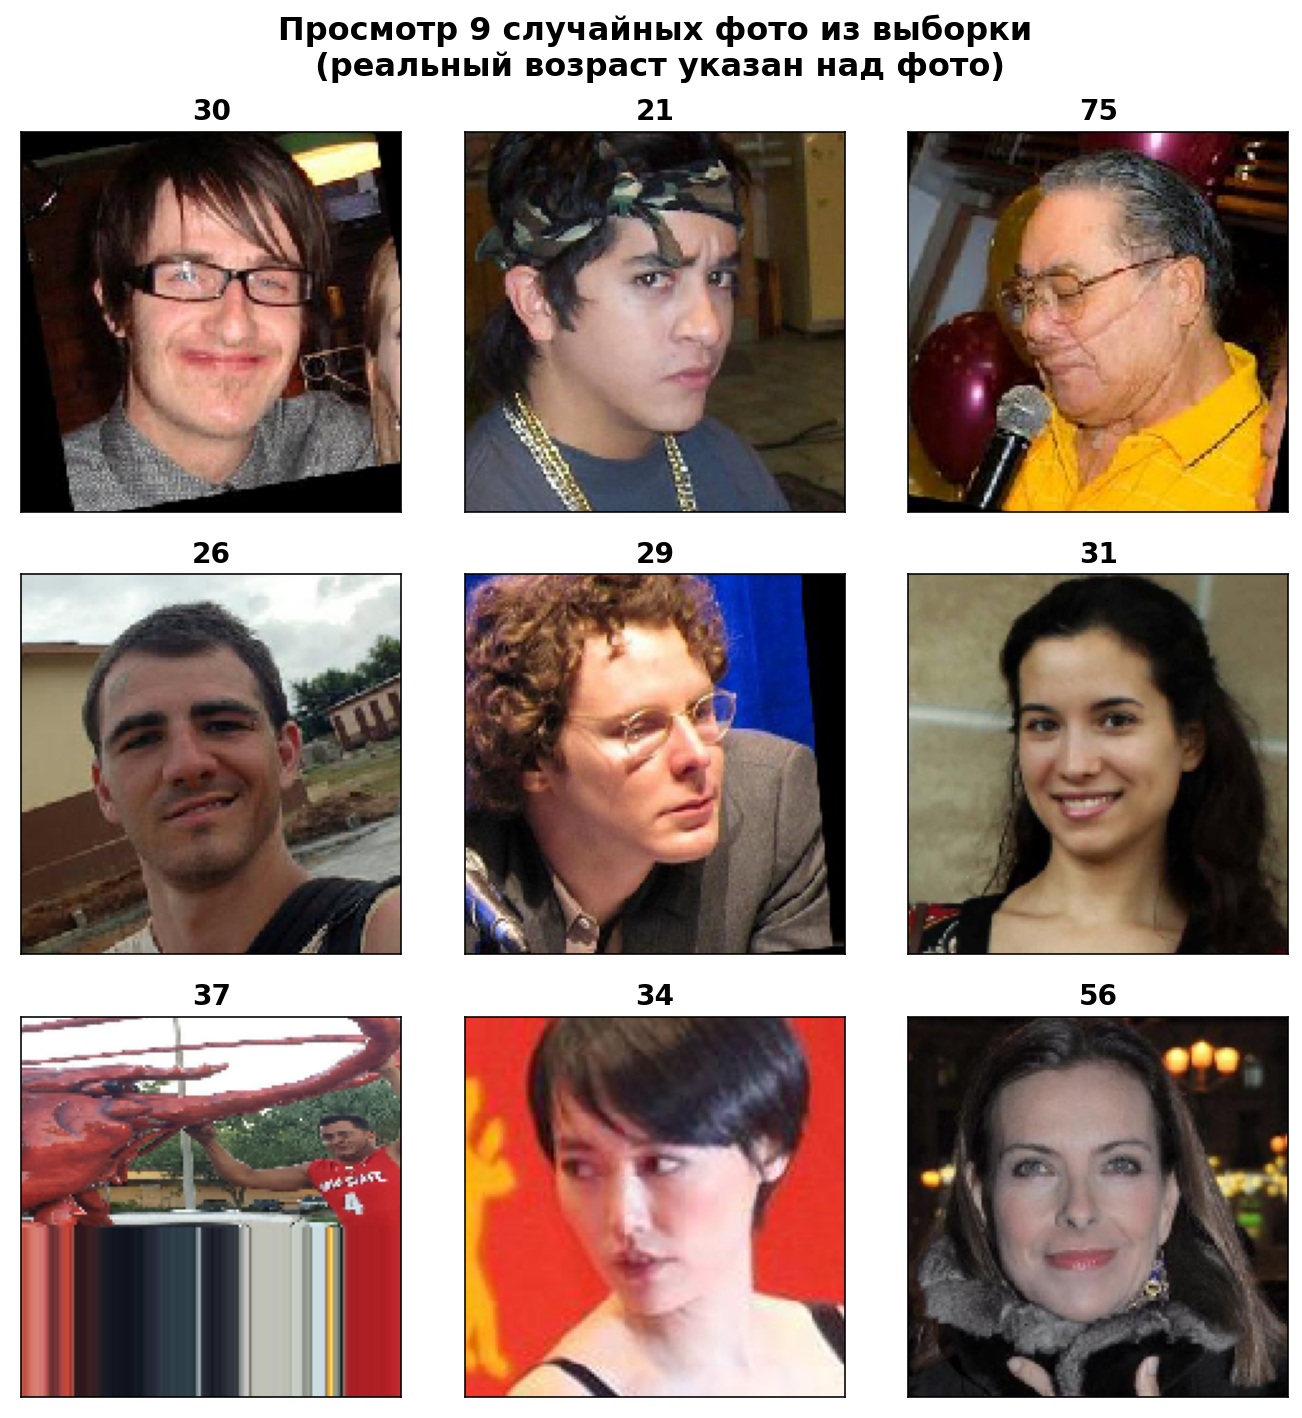

In [ ]:
# получаем фото и ее значение возраста
features, target = next(train_generator)

# выводим 9 изображений
fig = plt.figure(figsize=(10, 10))
for i in range(9):
    fig.add_subplot(3, 3, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.suptitle('Просмотр 9 случайных фото из выборки\n (реальный возраст указан над фото)')
	# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

<font size="4"><b>Выводы по исследовательскому анализу фотографий из папки `final_files`</b></font>
- На фото люди разного возраста.
- В данных присутствуют как цветные, так и черно-белые фотографии.
- Они имеют разное качество, яркость, свойства.
- В некоторых фото присутствует поворот.
- Фотографии не обрезаны по лицу, в некоторых присутствует много фона и другие люди. Это увеличивает количество неинформативных признаков, что приводит к снижению метрики качества и увеличению времени обучения.

In [ ]:
# функция, которая выводит описательную статистику для количественного признака
# строит гистограмму распределения и
# диаграмму размаха

def build_hist_boxplot(data, b, feature_name):
    # входные данные: data - Series с количественным признаком,
    # b - количество бинов для гистограммы,
    # feature_name - название признака

    print(f'Статистика для {feature_name}\n\n {data.describe()}')

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))
    plt.suptitle(feature_name)

    data.plot(kind='hist', bins=b, ax=axes[0])
    axes[0].set_title('Гистограмма распределения')
    axes[0].set_ylabel('Частота')

    data.plot(kind='box', ax=axes[1], vert=False)
    axes[1].set_title('Разброс значений признака')
    axes[1].set_xlabel(feature_name)
    plt.show()

Статистика для Реальный возраст

 count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64


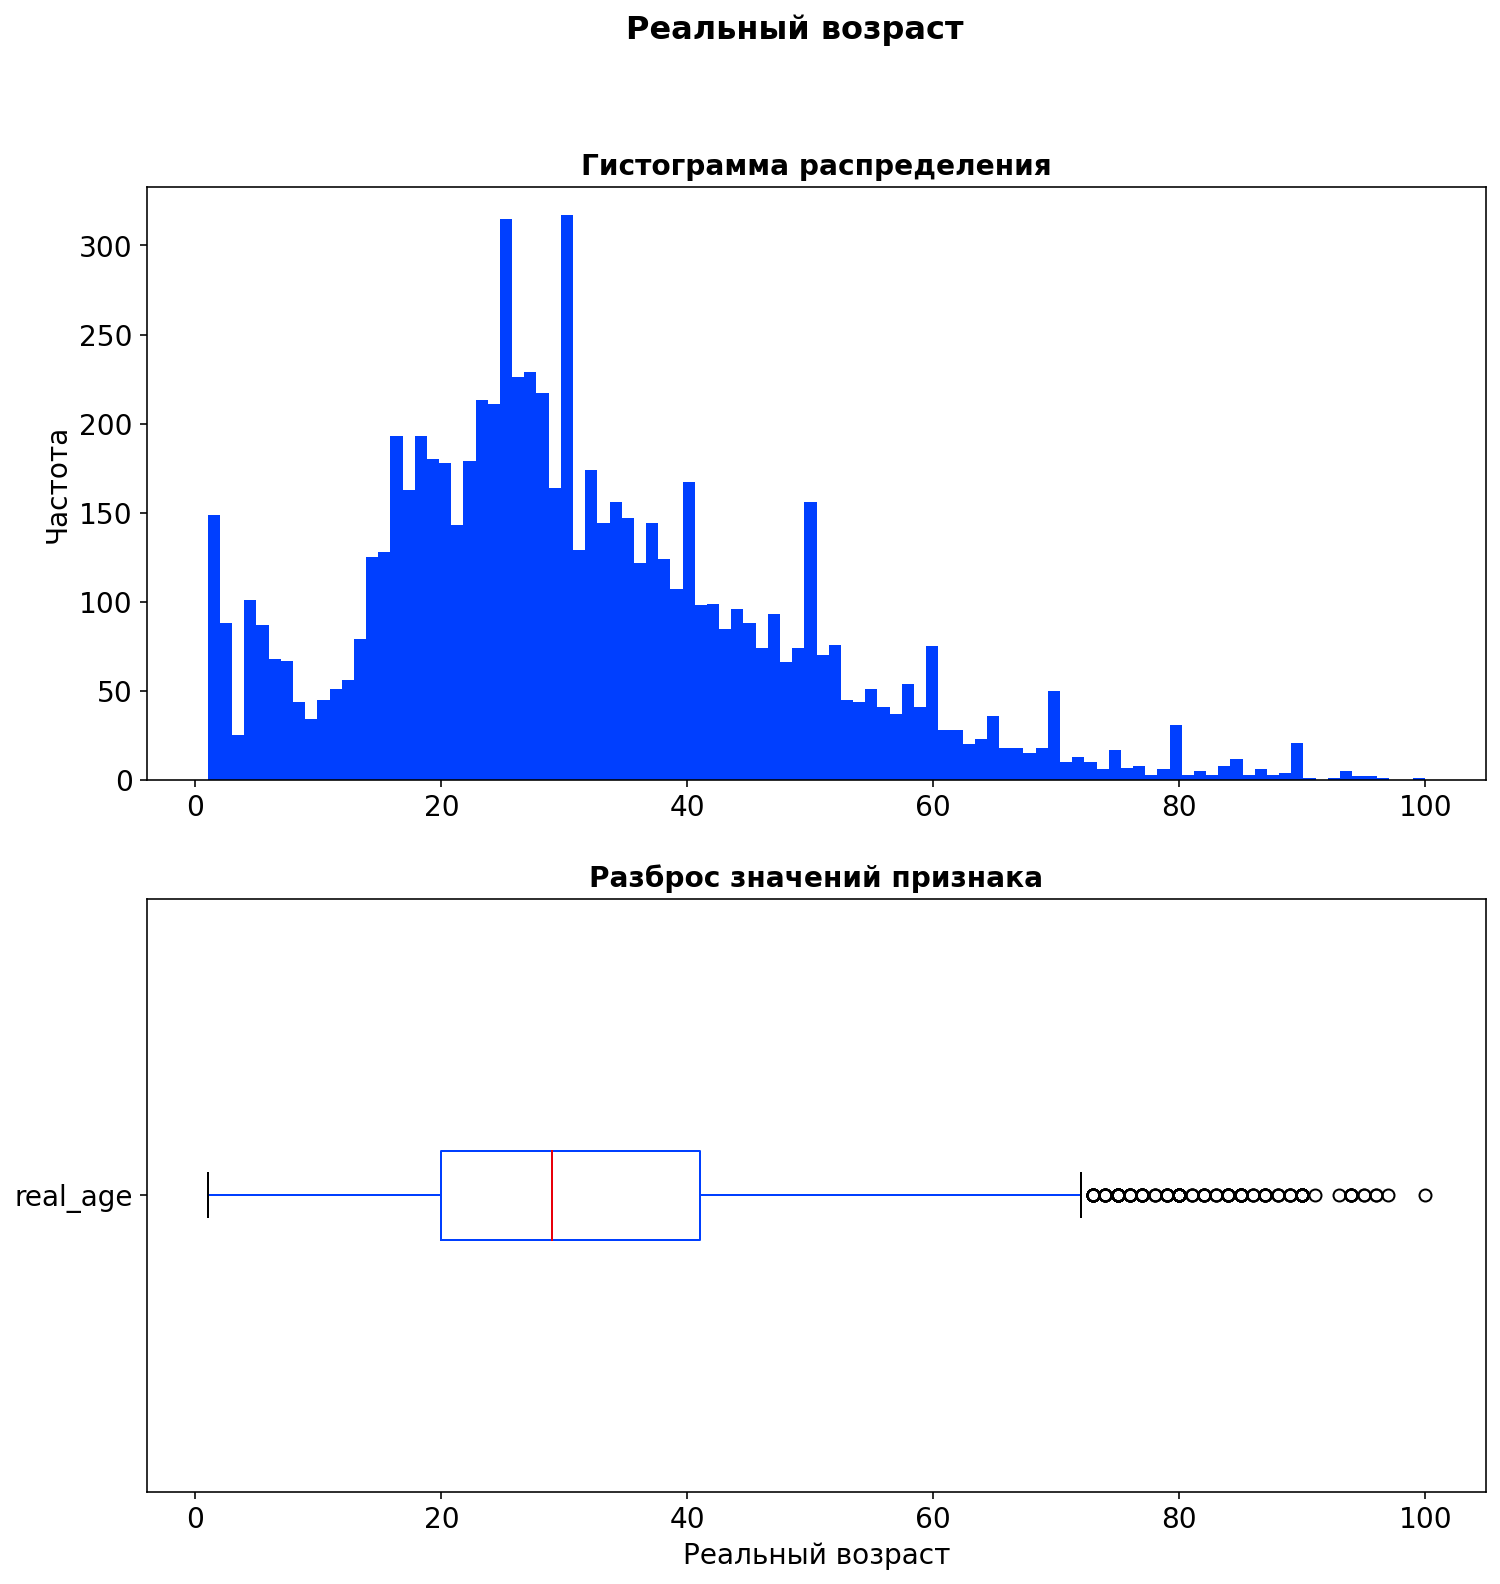

In [ ]:
# вызов функции для построения гистограммы и диаграммы размаха
build_hist_boxplot(labels['real_age'], 100, 'Реальный возраст')

In [ ]:
# расчет моды
labels['real_age'].mode()

0    30
dtype: int64

По гистограмме распределения видно, что в данных присутствует 2 пика значений, соответствующих детям до 10 лет и взрослым. Причем данных по взрослым больше, чем по детям, значит модель будет хуже определять детей. Среди взрослых данные также распределены неравномерно: большинство данных по людям среднего возраста (медиана равна 31 году, мода - 30 лет). Присутствует также длинный правый "хвост", соответствующий пожилым людям. Максимальный возраст людей в выборке - 100 лет.

<font size="4"><b>Выводы по исследовательскому анализу данных датафрейма labels</b></font>

- Большинство данных по людям среднего возраста (медиана равна 31 году, мода - 30 лет).
- Меньше данных по детям младше 10 лет и пожилым старше 70 лет, значит модель будет хуже их определять. Исходя из задачи проекта: не допустить продажу алкоголя детям и предложить интересующие товары, точностью определения детей до 10 лет и пожилых можно пренебречь и использовать метрику МАЕ для оценки качества модели. Она будет точнее отражать качество модели, если сильно большие или сильно маленькие значения можно рассматривать как выбросы и ими можно пренебречь.

## Обучение модели

Для обучения применим архитектуру ResNet50. Применим также алгоритм Adam для ускорения обучения модели. В качестве стартового шага градиентного спуска возьмем lr=0.0001.

```python
def load_train(path):
    # сохраняем данные из csv-файла в переменную labels
    labels = pd.read_csv(path + 'labels.csv')
    
    # инициализируем класс загрузчика данных ImageDataGenerator
    # указываем загрузчику, что валидация содержит 10% случайных объектов,
    # применяем отражение по горизонтали,
    # перемасштабируем данные, указав rescale=1./255
    datagen = ImageDataGenerator(validation_split=0.1,
                                 horizontal_flip=True,
                                 rescale=1./255)
    # извлекаем обучающие данные из папки с помощью flow_from_dataframe
    train_generator = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_generator

def load_test(path):
    # сохраняем данные из csv-файла в переменную labels
    labels = pd.read_csv(path + 'labels.csv')
    
    # инициализируем класс загрузчика данных ImageDataGenerator
    # указываем загрузчику, что валидация содержит 10% случайных объектов,
    # применяем отражение по горизонтали,
    # перемасштабируем данные, указав rescale=1./255
    datagen = ImageDataGenerator(validation_split=0.1,
                                 rescale=1./255)
    
    # извлекаем тестовые данные из папки с помощью flow_from_dataframe
    test_generator = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_generator

def create_model(input_shape):
    
    # выстраиваем архитектуру ResNet50
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    # обучаем модель
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

Train for 427 steps, validate for 48 steps
Epoch 1/10
427/427 - 66s - loss: 202.3463 - mae: 10.4653 - val_loss: 498.3181 - val_mae: 17.5757
Epoch 2/10
427/427 - 39s - loss: 84.5834 - mae: 7.0006 - val_loss: 120.7303 - val_mae: 8.1127
Epoch 3/10
427/427 - 39s - loss: 58.3290 - mae: 5.8215 - val_loss: 84.6451 - val_mae: 6.7901
Epoch 4/10
427/427 - 39s - loss: 42.0100 - mae: 4.9134 - val_loss: 79.7626 - val_mae: 7.0404
Epoch 5/10
427/427 - 39s - loss: 31.3041 - mae: 4.2972 - val_loss: 74.1003 - val_mae: 6.5066
Epoch 6/10
427/427 - 39s - loss: 24.0805 - mae: 3.7499 - val_loss: 74.8376 - val_mae: 6.4836
Epoch 7/10
427/427 - 39s - loss: 19.0689 - mae: 3.3193 - val_loss: 68.7397 - val_mae: 6.3356
Epoch 8/10
427/427 - 39s - loss: 16.4271 - mae: 3.0887 - val_loss: 71.4954 - val_mae: 6.3966
Epoch 9/10
427/427 - 39s - loss: 14.6563 - mae: 2.8911 - val_loss: 63.8080 - val_mae: 6.1801
Epoch 10/10
427/427 - 39s - loss: 14.3538 - mae: 2.8597 - val_loss: 68.0335 - val_mae: 6.2876
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
48/48 - 3s - loss: 68.0335 - mae: 6.2876
Test MAE: 6.2876

```

## Анализ обученной модели

Для обучения использовалась сеть ResNet50 и алгоритм Adam со скоростью обучения 0.0001. Критерий значения метрики МАЕ не больше 8 был достигнут уже на 3 эпохах. МАЕ на тестовых данных на 10 эпохе равен 6.29 годам, значит модель в среднем ошибается на 6.3 года.